In [6]:
from utils import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import hstack
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
input_dir='Data/'
nrows=5000
usecols = ['id','clean_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = pd.read_csv(input_dir + 'train_processed_stage1.csv', usecols=usecols)
# df_test = pd.read_csv(input_dir + 'test_processed_stage1.csv',nrows=nrows)

In [8]:
def vectorize_tfidf(X_train, X_test):
    #Vectorize comments 
    word_vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,1), max_features=10000, stop_words='english', \
                                   strip_accents='unicode')
    
    #Build word vocabulary from X_train
    X_train_word_feats = word_vect.fit_transform(X_train['clean_text'].values.astype('U'))
    X_test_word_feats = word_vect.transform(X_test['clean_text'].values.astype('U'))
    
    print("Shape of word vectorized train and test datasets are {} and {}".format(X_train_word_feats.get_shape(), \
                                                                             X_test_word_feats.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_word_feats.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_word_feats))
    
    word_feature_names = np.array(word_vect.get_feature_names())
    
    #Vectorize comments using characters
    #People often try to obfuscate bad words with additional characters. Using character n-grams can potentially 
    #detect those.
    char_vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(2,6), max_features=5000, stop_words='english',\
                                analyzer='char', strip_accents='unicode')
    
    #Build char vocabulary from X_train
    X_train_char_feats = char_vect.fit_transform(X_train['clean_text'].values.astype('U'))
    X_test_char_feats = char_vect.transform(X_test['clean_text'].values.astype('U'))
    
    print("Shape of char vectorized train and test datasets are {} and {}".format(X_train_char_feats.get_shape(), \
                                                                             X_test_char_feats.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_char_feats.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_char_feats))
    
    #Stack sparse matrices horizontally (column wise)
    train_features = hstack([X_train_word_feats, X_train_char_feats])
    test_features = hstack([X_test_word_feats, X_test_char_feats])
    return train_features, test_features, word_feature_names

# Logistic Regression only with comments

In [9]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X = df_train[['id','clean_text']]
y = df_train[class_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_features, test_features, word_feature_names = vectorize_tfidf(X_train, X_test)

Shape of word vectorized train and test datasets are (106912, 10000) and (52659, 10000)
Number of unique words in the dataset is  10000
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Shape of char vectorized train and test datasets are (106912, 5000) and (52659, 5000)
Number of unique words in the dataset is  5000
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>


In [17]:
# #https://buhrmann.github.io/tfidf-analysis.html
# def top_tfidf_feats(row, features, top_n=25):
#     ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
#     topn_ids = np.argsort(row)[::-1][:top_n]
#     top_feats = [(features[i], row[i]) for i in topn_ids]
#     df = pd.DataFrame(top_feats)
#     df.columns = ['feature', 'tfidf']
#     return df

# def top_feats_in_doc(Xtr, features, row_id, top_n=25):
#     ''' Top tfidf features in specific document (matrix row) '''
#     row = np.squeeze(Xtr[row_id].toarray())
#     return top_tfidf_feats(row, features, top_n)

# def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
#     ''' Return the top n features that on average are most important amongst documents in rows
#         indentified by indices in grp_ids. '''
    
#     D = Xtr[grp_ids].toarray()

#     D[D < min_tfidf] = 0
#     tfidf_means = np.mean(D, axis=0)
#     return top_tfidf_feats(tfidf_means, features, top_n)

# # modified for multilabel multiclass
# def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
#     ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
#         calculated across documents with the same class label. '''
#     dfs = []
# #     cols=train_tags.columns
    
# #     for col in cols:
#     for col in class_names:
# #         ids = train_tags.index[train_tags[col]==1]
#         ids = X_train.index[y_train[col]==1]
#         feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
#         feats_df.label = label
#         dfs.append(feats_df)
#     return dfs

In [18]:
#get top n for unigrams
tfidf_top_n_per_class=top_feats_by_class(train_features, word_feature_names)

TypeError: 'coo_matrix' object is not subscriptable

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

CV score for class toxic is 0.9610120299778208
Validation score for class toxic is 0.9642673175645807


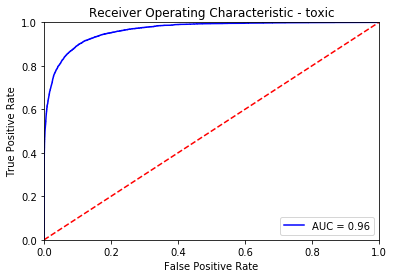

CV score for class severe_toxic is 0.9858049337265142
Validation score for class severe_toxic is 0.9841575499459229


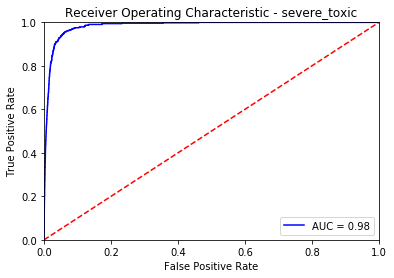

CV score for class obscene is 0.9794660332956672
Validation score for class obscene is 0.9806412299213567


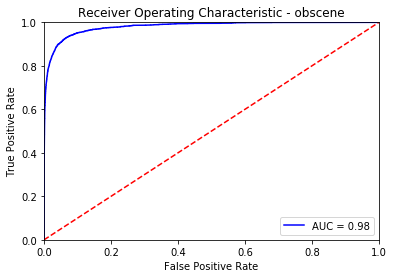

CV score for class threat is 0.9758294878625055
Validation score for class threat is 0.9810527769229768


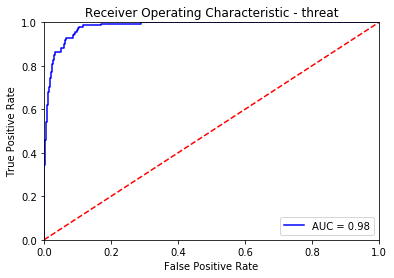

CV score for class insult is 0.9710634861481408
Validation score for class insult is 0.9735697289693631


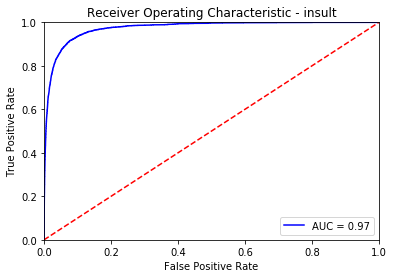

CV score for class identity_hate is 0.9622711568103118
Validation score for class identity_hate is 0.9712521665505586


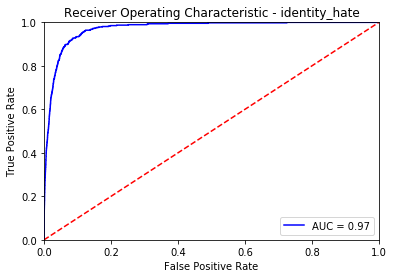

Total CV score is 0.9725745213034934
Total Validation score is 0.9758234616457933


In [7]:
cv_scores = []
scores = []
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    cv_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    probs = classifier.predict_proba(test_features)
    preds = probs[:, 1]
    
    fpr, tpr, threshold = metrics.roc_curve(y_test[class_name], preds)
    roc_auc = metrics.auc(fpr, tpr)
    scores.append(roc_auc)
    print('Validation score for class {} is {}'.format(class_name, roc_auc))
    
    plt.title('Receiver Operating Characteristic - '+ class_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('Total CV score is {}'.format(np.mean(cv_scores))) 
print('Total Validation score is {}'.format(np.mean(scores))) 

# Logistic Regression with comments and meta features

In [52]:
df_train = pd.read_csv(input_dir + 'train_processed_stage1.csv')

In [53]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
meta_features_cols = ['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_question_marks', \
 'num_punctuation', 'num_symbols', 'num_words', 'num_unique_words', 'words_vs_unique', 'num_smilies', 'ant_slash_n', \
 'nb_fk', 'nb_sk', 'nb_dk', 'nb_you', 'nb_ng', 'nb_mother', 'start_with_columns', 'has_timestamp', 'has_date_long', \
 'has_date_short', 'has_http', 'has_mail', 'has_image', 'has_ip', 'has_emphasize_equal', 'has_emphasize_quotes', \
 'has_star', 'unknown_fasttext']

X = df_train[['id', 'clean_text'] + meta_features_cols]
y = df_train[class_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_features, test_features = vectorize_tfidf(X_train[['clean_text']], X_test[['clean_text']])

train_features = hstack([train_features, X_train[meta_features_cols].astype(float)])
test_features = hstack([test_features, X_test[meta_features_cols].astype(float)])

Shape of word vectorized train and test datasets are (106912, 10000) and (52659, 10000)
Number of unique words in the dataset is  10000
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Shape of char vectorized train and test datasets are (106912, 5000) and (52659, 5000)
Number of unique words in the dataset is  5000
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>


## With C=0.1

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class toxic is 0.8735518289789729


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class toxic is 0.8721610288878403


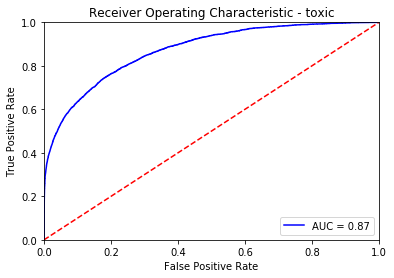

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class severe_toxic is 0.9251866900317861


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class severe_toxic is 0.9164526107143771


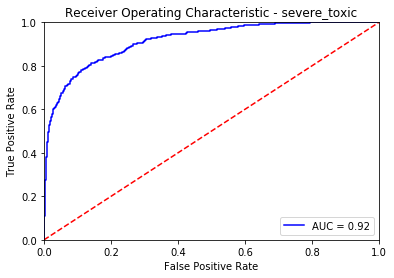

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class obscene is 0.9074191150578939


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class obscene is 0.9018120178699076


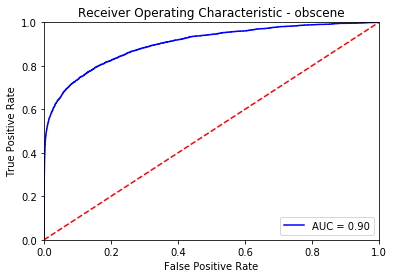

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class threat is 0.7252561213253476


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class threat is 0.7327897633698965


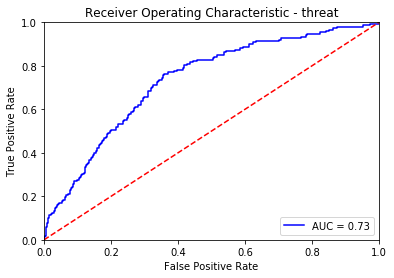

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class insult is 0.8802115761672277


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class insult is 0.8751535339187109


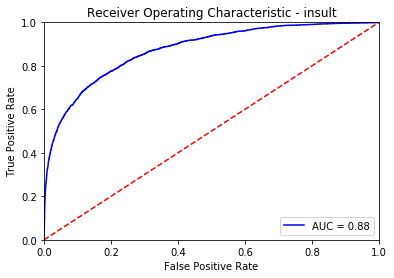

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class identity_hate is 0.775864577180565


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class identity_hate is 0.7786750319805728


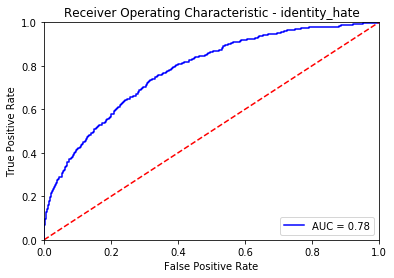

Total CV score is 0.8479149847902988
Total Validation score is 0.8461739977902175


In [54]:
cv_scores = []
scores = []
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    cv_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    probs = classifier.predict_proba(test_features)
    preds = probs[:, 1]
    
    fpr, tpr, threshold = metrics.roc_curve(y_test[class_name], preds)
    roc_auc = metrics.auc(fpr, tpr)
    scores.append(roc_auc)
    print('Validation score for class {} is {}'.format(class_name, roc_auc))
    
    plt.title('Receiver Operating Characteristic - '+ class_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('Total CV score is {}'.format(np.mean(cv_scores))) 
print('Total Validation score is {}'.format(np.mean(scores))) 

## With C=0.01 and max_iter=1000 

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class toxic is 0.9054804346439042
Validation score for class toxic is 0.9146886089766443


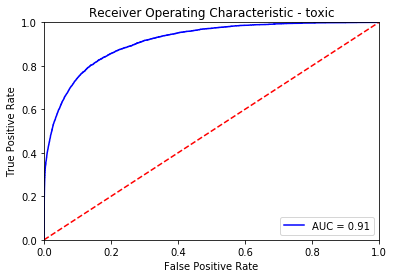

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class severe_toxic is 0.950807382429553


KeyboardInterrupt: 

In [56]:
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(C=0.01, solver='sag',max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    cv_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    probs = classifier.predict_proba(test_features)
    preds = probs[:, 1]
    
    fpr, tpr, threshold = metrics.roc_curve(y_test[class_name], preds)
    roc_auc = metrics.auc(fpr, tpr)
    scores.append(roc_auc)
    print('Validation score for class {} is {}'.format(class_name, roc_auc))
    
    plt.title('Receiver Operating Characteristic - '+ class_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('Total CV score is {}'.format(np.mean(cv_scores))) 
print('Total Validation score is {}'.format(np.mean(scores))) 

## With C=0.1 and max_iter=1000

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class toxic is 0.9396468200768909


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class toxic is 0.942933300155042


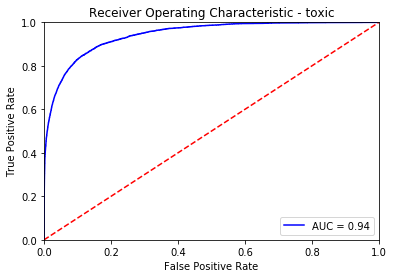

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 

In [57]:
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag',max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    cv_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    probs = classifier.predict_proba(test_features)
    preds = probs[:, 1]
    
    fpr, tpr, threshold = metrics.roc_curve(y_test[class_name], preds)
    roc_auc = metrics.auc(fpr, tpr)
    scores.append(roc_auc)
    print('Validation score for class {} is {}'.format(class_name, roc_auc))
    
    plt.title('Receiver Operating Characteristic - '+ class_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('Total CV score is {}'.format(np.mean(cv_scores))) 
print('Total Validation score is {}'.format(np.mean(scores))) 

## With C=2.0 and max_iter=1000

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class toxic is 0.9435362987889505


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class toxic is 0.945569177184217


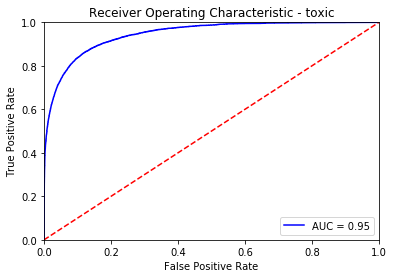

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class severe_toxic is 0.956858646776185


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class severe_toxic is 0.9526748235848075


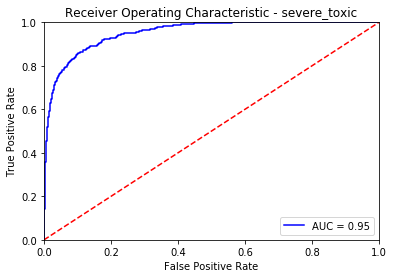

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class obscene is 0.9585244135212007


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class obscene is 0.959369698382003


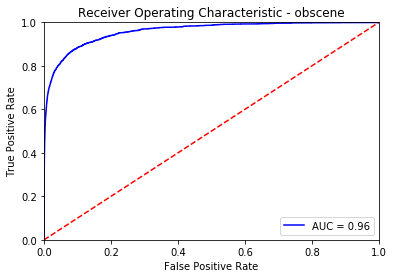

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class threat is 0.85715053968048


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class threat is 0.8643809898028634


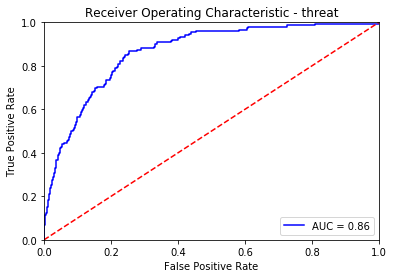

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class insult is 0.9467858488517334


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class insult is 0.9487389612319894


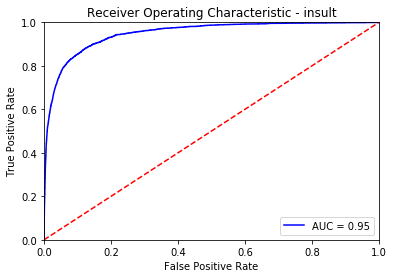

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class identity_hate is 0.8731618437178118


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for class identity_hate is 0.881355370921755


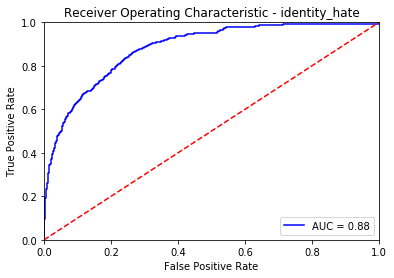

Total CV score is 0.9002266654551073
Total Validation score is 0.8953760979989237


In [62]:
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(C=2.0, solver='sag',max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    cv_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    probs = classifier.predict_proba(test_features)
    preds = probs[:, 1]
    
    fpr, tpr, threshold = metrics.roc_curve(y_test[class_name], preds)
    roc_auc = metrics.auc(fpr, tpr)
    scores.append(roc_auc)
    print('Validation score for class {} is {}'.format(class_name, roc_auc))
    
    plt.title('Receiver Operating Characteristic - '+ class_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('Total CV score is {}'.format(np.mean(cv_scores))) 
print('Total Validation score is {}'.format(np.mean(scores))) 